In [11]:
import pandas as pd
# Prerpiprava Dát
# precitam subory
pre_game = pd.read_csv('pred.csv')
game = pd.read_csv('mouse_ac.csv')
post_game = pd.read_csv('post.csv')

# premenujem a pouzijem len rovnake username
pre_game = pre_game.rename(columns={'Zadajte používateľské meno (Rovnaké ako v hre)': 'username'})
post_game = post_game.rename(columns={'Zadajte používateľské meno ': 'username'})

# mergnem na username
merged_data = pre_game.merge(game, on='username').merge(post_game, on='username')

# dropnem duplikaty
merged_data = merged_data.drop_duplicates(subset=['username'])

# premenujem pre jednoduchosť...
merged_data = merged_data.rename(columns={
    'Na stupnici od 1 do 10, aké dôležité je pre vás mať kontrolu nad intenzitou svojich emócií?\n1 nedôležité         \n10 veľmi dôležité': 'Emotion control importance',
    'Ako často hrávate videohry ?\nkaždý deň až skoro vôbec': 'Gaming frequency',
    'Ste pravák alebo ľavák ?': 'Handedness',
    'Koľko hodín týždenne hrávate videohry v priemere?\nSkoro vôbec až viac ako 10 hodín': 'Gaming hours per week',
    'Ako ste sa cítili počas hrania hry?\nveľmi šťastne až veľmi nešťastne': 'Emotions while gaming',
    'Aká náročná bola pre vás hra?\nveľmi ľahká až veľmi náročná': 'Game difficulty',
    'Ako by ste na stupnici od 1 do 10 ohodnotili to ako moc ste si užili hru?': 'Enjoyment rating',
    'Splnila hra vaše očakávania?': 'Game expectations',
    'Ako sa vám darilo kontrolovať intenzitu emócií počas hry?': 'Emotion control during gaming',
    'Chceli by ste si hru zahrať znova ? ': 'Game replayability',
    'Vek': 'Age',
    'Hráte videohry na konzole, PC alebo na mobile': 'Platform',
    'Aký je váš obľúbený žáner videohier?': 'Genre',
    'Máte už nejaké skúsenosti s hraním hier prostredníctvom klávesnice a myši?':'Expirience'
})

merged_data = merged_data.drop('Časová značka_x', axis=1)
merged_data = merged_data.drop('Časová značka_y', axis=1)

#prehodim to aby to bolo rovnake pre vsetky
merged_data['Pohlavie'].replace({'Muž': 'Male', 'Žena': 'Female'}, inplace=True)
merged_data['Pohlavie'] = merged_data['Pohlavie'].map({'Male': 1, 'Female': 0})
#prerabam striny na INT aby to model vedel pouzit spravne...
merged_data['Handedness'] = merged_data['Handedness'].map({'Right-handed': 1, 'Left-handed': 0})
merged_data['Expirience'] = merged_data['Expirience'].map({'Yes': 1, 'No': 0})
merged_data['Game expectations'] = merged_data['Game expectations'].map({'Yes': 1, 'No': 0})
merged_data['Game replayability'] = merged_data['Game replayability'].map({'Yes': 1, 'No': 0})

merged_data['Gaming frequency'] = merged_data['Gaming frequency'].map({
    'Daily': 5, 
    'A few times a week': 4, 
    'Once a week': 3, 
    'A few times a month': 2, 
    'Rarely': 1
})
merged_data['Gaming hours per week'] = merged_data['Gaming hours per week'].map({
    'More than 10 hours': 5, 
    '5-10 hours': 4, 
    '3-5 hours': 3, 
    '1-3 hours': 2, 
    'Less than 1 hour': 1
})
merged_data['Game difficulty'] = merged_data['Game difficulty'].map({
    'Very difficult': 5, 
    'Difficult': 4, 
    'Neutral': 3, 
    'Easy': 2, 
    'Very easy': 1
})
merged_data['Emotion control during gaming'] = merged_data['Emotion control during gaming'].map({
    'Very Poor': 5, 
    'Poor': 4, 
    'Neutral': 3, 
    'Good': 2, 
    'Excellent': 1
})
#V pripade ze je viac moznosti by som dostal NaN keby ich nescitam..
merged_data['Platform'] = merged_data['Platform'].str.split(';').apply(lambda x: sum([{
    'Console': 4, 
    'PC': 3, 
    'Mobile device': 2, 
    'None': 1
}.get(g, 0) for g in x])/len(x))
merged_data['Genre'] = merged_data['Genre'].str.split(';').apply(lambda x: sum([{
    'Action': 5,
    'Adventure': 4,
    'Simulation': 3,
    'RPG': 2,
    'Strategy': 1
}.get(g, 0) for g in x])/len(x))

merged_data['Emotions while gaming'] = merged_data['Emotions while gaming'].map({
    'Very happy': 'Excited',
    'Happy': 'Pleased',
    'Neutral': 'Calm',
    'Unhappy': 'Frustrated',
    'Very unhappy': 'Angry'
})

# export ktory nasledne otvaram neskor snim pracujem...
merged_data.to_csv('merged_data.csv', index=False)


In [32]:
print(merged_data.head(50))

          username  Age  Pohlavie  Handedness  Gaming hours per week  \
0           Mirico   37         1           1                      1   
1            Timbo   24         1           1                      5   
2            Betka   24         0           1                      2   
3           Havran   50         1           1                      3   
4            Peter   24         1           1                      1   
5               dq   24         1           1                      5   
6           Soky90   24         1           1                      5   
7            Petra   19         0           1                      2   
8            Sidka   50         0           1                      1   
9            Sixty   23         1           1                      1   
10          blabla   24         1           1                      1   
11         Dominik   23         1           1                      2   
12             Sss   24         1           1                   

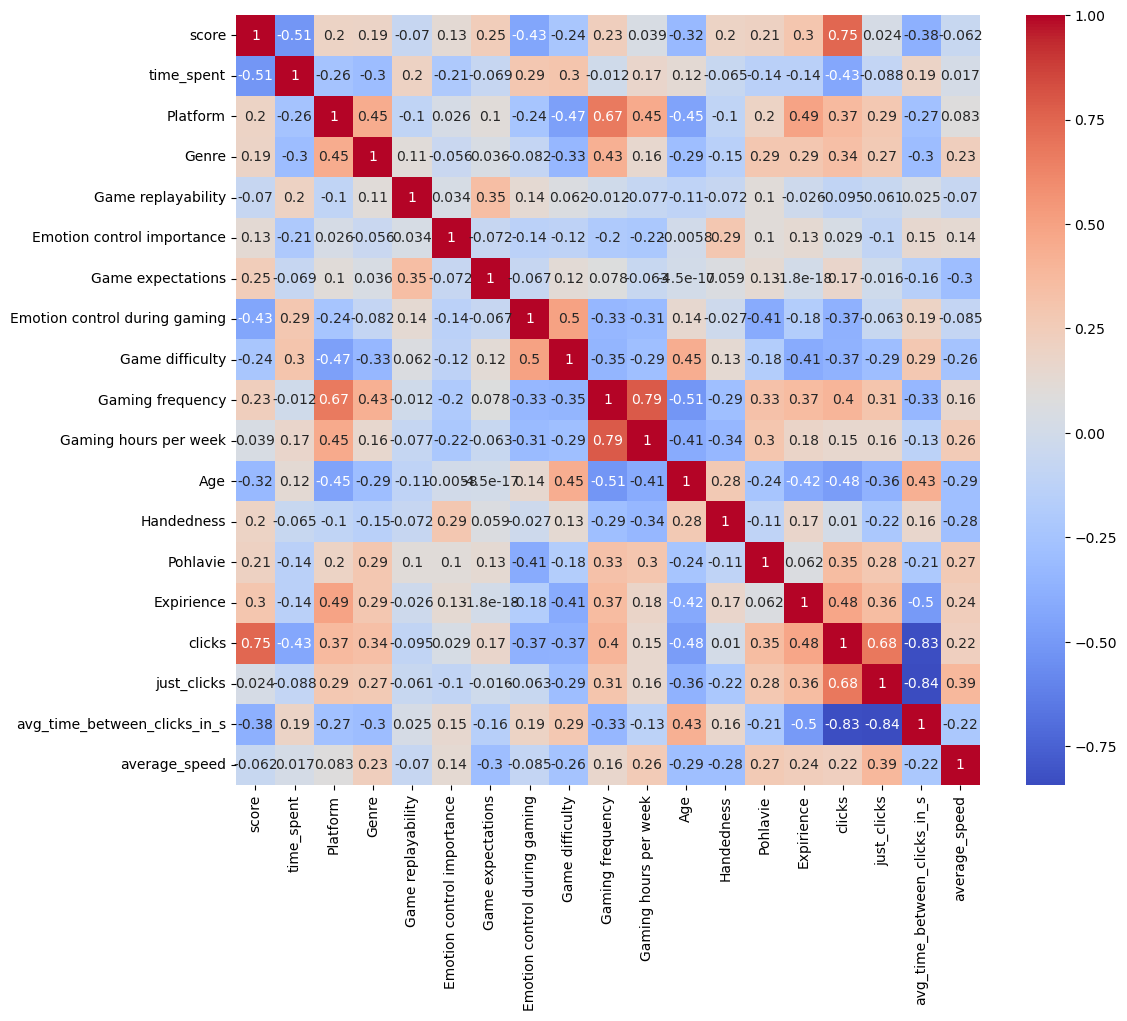

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Potrebujem vediet ktore premenne su pouzitelne, ktore mozem vylucit atd...
merged_data = pd.read_csv('merged_data.csv')

# premenne
features = ['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations',
            'Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age',
            'Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']

# korelacna analyza
corr = merged_data[features].corr()

# nakreslim heatmapu
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

# rozdeli na trenovacie testovacie 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# trening modelu
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predikcie na testovacich datach
y_pred = rf.predict(X_test)

# presnost modelu
accuracy = accuracy_score(y_test, y_pred)
print("RF without oversampling Accuracy:", accuracy)

# dolezitost jednotlivych hodnot v danom modeli
importances = pd.Series(data=rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

# % dolezitost
importance_percentage = (importances_sorted / importances_sorted.sum()) * 100

# tabulka dolezitosti
feature_importances = pd.DataFrame({
    'Importance': importances_sorted,
    'Importance %': importance_percentage.round(2)
})

print(feature_importances)

RF without oversampling Accuracy: 0.125
                               Importance  Importance %
score                            0.121582         12.16
clicks                           0.118358         11.84
Emotion control during gaming    0.116991         11.70
avg_time_between_clicks_in_s     0.094428          9.44
just_clicks                      0.077309          7.73
average_speed                    0.068466          6.85
Game replayability               0.062044          6.20
Emotion control importance       0.055869          5.59
Genre                            0.044170          4.42
time_spent                       0.042291          4.23
Game difficulty                  0.040263          4.03
Age                              0.036076          3.61
Gaming frequency                 0.032124          3.21
Platform                         0.022232          2.22
Game expectations                0.020198          2.02
Gaming hours per week            0.019792          1.98
Pohlavie

In [9]:
#Random forest s oversamplingom siel z 0.125 na 0.94 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

# prevzorkovanie / oversampling
oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# vykon modelu
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("RF with oversampling Accuracy:", accuracy)
print("RF with oversampling Precision:", precision)
print("RF with oversampling Recall:", recall)
print("RF with oversampling F1 Score:", f1)

importances = pd.Series(data=rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

importance_percentage = (importances_sorted / importances_sorted.sum()) * 100

feature_importances = pd.DataFrame({
    'Importance': importances_sorted,
    'Importance %': importance_percentage.round(2)
})

print(feature_importances)


RF with oversampling Accuracy: 0.9473684210526315
RF with oversampling Precision: 0.9578947368421052
RF with oversampling Recall: 0.9473684210526315
RF with oversampling F1 Score: 0.9465329991645781
                               Importance  Importance %
score                            0.109089         10.91
Genre                            0.106891         10.69
average_speed                    0.086078          8.61
Game replayability               0.075604          7.56
clicks                           0.074981          7.50
avg_time_between_clicks_in_s     0.072875          7.29
just_clicks                      0.068396          6.84
Game difficulty                  0.056813          5.68
Game expectations                0.056378          5.64
Platform                         0.050104          5.01
Gaming frequency                 0.047413          4.74
Emotion control during gaming    0.041306          4.13
time_spent                       0.040071          4.01
Gaming hours per 

In [12]:
# DT 0.375 s oversamplingom 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_oversampled, y_train_oversampled)

y_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print("DT Accuracy:", accuracy)
print("DT Precision:", precision)
print("DT Recall:", recall)
print("DT F1 Score:", f1)

# vypis
importances = pd.Series(data=dt.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()
importances_df = pd.DataFrame({'Importance': importances_sorted.values,
                               'Importance %': importances_sorted.values / importances_sorted.sum() * 100},
                              index=importances_sorted.index)
print(importances_df)

DT Accuracy: 0.375
DT Precision: 0.2708333333333333
DT Recall: 0.375
DT F1 Score: 0.3142857142857143
                               Importance  Importance %
Gaming frequency                 0.000000      0.000000
just_clicks                      0.000000      0.000000
clicks                           0.000000      0.000000
Expirience                       0.000000      0.000000
Pohlavie                         0.000000      0.000000
Handedness                       0.000000      0.000000
Gaming hours per week            0.000000      0.000000
avg_time_between_clicks_in_s     0.000000      0.000000
average_speed                    0.000000      0.000000
Game expectations                0.000000      0.000000
Platform                         0.000000      0.000000
Game difficulty                  0.000000      0.000000
Emotion control during gaming    0.045351      4.535147
Emotion control importance       0.077560      7.756012
time_spent                       0.111317     11.131725
Age

In [13]:
#DT 0.75 bez oversamplingu 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# trening
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# predikcie
y_pred = dt.predict(X_test)

# evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# zistim dolezitost jednotlivych premennych v danom modeli
importances = pd.Series(data=dt.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()

# tabulka
importances_df = pd.DataFrame({'Importance': importances_sorted.values,
                               'Importance %': importances_sorted.values / importances_sorted.sum() * 100},
                              index=importances_sorted.index)

# vypisem
print("DT Accuracy:", accuracy)
print("DT Precision:", precision)
print("DT Recall:", recall)
print("DT F1 Score:", f1)
print("\nFeature Importances:\n", importances_df)

DT Accuracy: 0.75
DT Precision: 0.6979166666666666
DT Recall: 0.75
DT F1 Score: 0.6880952380952381

Feature Importances:
                                Importance  Importance %
score                            0.000000      0.000000
Platform                         0.000000      0.000000
just_clicks                      0.000000      0.000000
Expirience                       0.000000      0.000000
Emotion control importance       0.000000      0.000000
Game expectations                0.000000      0.000000
Pohlavie                         0.000000      0.000000
Game difficulty                  0.000000      0.000000
Handedness                       0.000000      0.000000
Gaming hours per week            0.000000      0.000000
Age                              0.000000      0.000000
time_spent                       0.033392      3.339203
Gaming frequency                 0.039653      3.965304
Genre                            0.073641      7.364135
avg_time_between_clicks_in_s     0.079

F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
#SVM model klesol nepomohol ani oversampling
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability',
                'Emotion control importance', 'Game expectations', 'Emotion control during gaming',
                'Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness',
                'Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s',
                'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("SVM with oversampling Accuracy:", accuracy)
print("SVM with oversampling Precision:", precision)
print("SVM with oversampling Recall:", recall)
print("SVM with oversampling F1 Score:", f1)

SVM with oversampling Accuracy: 0.375
SVM with oversampling Precision: 0.5
SVM with oversampling Recall: 0.375
SVM with oversampling F1 Score: 0.4


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability',
                'Emotion control importance', 'Game expectations', 'Emotion control during gaming',
                'Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness',
                'Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s',
                'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("SVM Accuracy:", accuracy)
print("SVM Precision:", precision)
print("SVM Recall:", recall)
print("SVM F1 Score:", f1)


SVM Accuracy: 0.375
SVM Precision: 0.5
SVM Recall: 0.375
SVM F1 Score: 0.4


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# trening modelu
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("NB without oversampling Accuracy:", accuracy)
print("NB Precision:", precision)
print("NB Recall:", recall)
print("NB F1 Score:", f1)

NB without oversampling Accuracy: 0.5
NB Precision: 0.4375
NB Recall: 0.5
NB F1 Score: 0.4583333333333333


F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("NB with oversampling Accuracy:", accuracy)
print("NB with oversampling Precision:", precision)
print("NB with oversampling Recall:", recall)
print("NB with oversampling F1 Score:", f1)


NB with oversampling Accuracy: 0.5
NB with oversampling Precision: 0.4375
NB with oversampling Recall: 0.5
NB with oversampling F1 Score: 0.4583333333333333


F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("KNN with oversampling Accuracy:", accuracy)
print("KNN with oversampling Precision:", precision)
print("KNN with oversampling Recall:", recall)
print("KNN with oversampling F1 Score:", f1)

KNN with oversampling Accuracy: 0.25
KNN with oversampling Precision: 0.16666666666666666
KNN with oversampling Recall: 0.20833333333333331
KNN with oversampling F1 Score: 0.18333333333333335


F:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("KNN without oversampling Accuracy:", accuracy)
print("KNN Precision:", precision)
print("KNN Recall:", recall)
print("KNN F1 Score:", f1)

KNN without oversampling Accuracy: 0.125
KNN Precision: 0.03571428571428571
KNN Recall: 0.125
KNN F1 Score: 0.05555555555555556


F:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


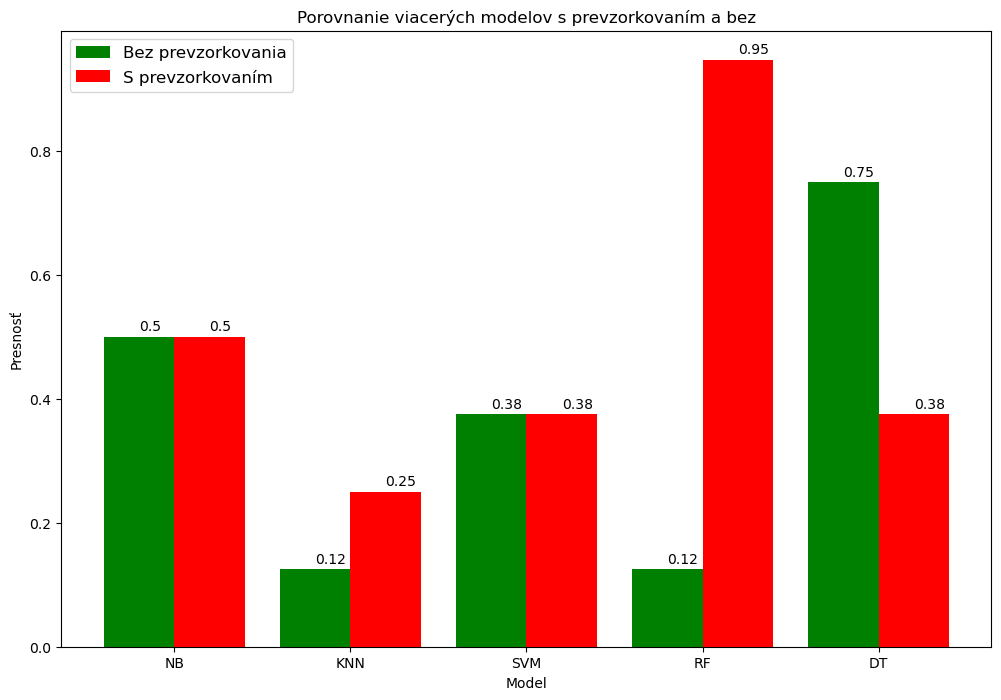

In [22]:
import matplotlib.pyplot as plt

# vysledky kvoli grafu
results = {
    'NB': [0.5, 0.5],
    'KNN': [0.125, 0.25],
    'SVM': [0.375, 0.375],
    'RF': [0.125, 0.947],
    'DT': [0.75, 0.375]
}

# modely a farby
model_names = ['NB', 'KNN', 'SVM', 'RF', 'DT']
colors = ['green', 'red']

# vizualizacia
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.4
x = [i for i in range(len(model_names))]

for i, model in enumerate(model_names):
    ax.bar(x[i], results[model][0], width, color=colors[0], label='Bez prevzorkovania')
    ax.bar(x[i]+width, results[model][1], width, color=colors[1], label='S prevzorkovaním')
    ax.text(x[i], results[model][0] + 0.01, str(round(results[model][0], 2)))
    ax.text(x[i] + width, results[model][1] + 0.01, str(round(results[model][1], 2)))

# nazov a popisky grafu
ax.set_xlabel('Model')
ax.set_ylabel('Presnosť')
ax.set_title('Porovnanie viacerých modelov s prevzorkovaním a bez')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(model_names)

# legenda
ax.legend(['Bez prevzorkovania', 'S prevzorkovaním'], loc='upper left', fontsize='large')

plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

# prekonvertovanie na ciselne dodatocne
le = LabelEncoder()
y = le.fit_transform(y)

# oversampling na vybalancovanie tried
oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Architektura modelu
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(5, activation='softmax'))

# kompilovanie modelu
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# trenovanie modelu
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# predikcie modelu na testovacich datach
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

# vykon
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling Accuracy:", accuracy)
print("Neural Network with oversampling Precision:", precision)
print("Neural Network with oversampling Recall:", recall)
print("Neural Network with oversampling F1 Score:", f1)

Epoch 1/50
3/3 [==============================] - 1s 95ms/step - loss: 84.5397 - accuracy: 0.2877 - val_loss: 82.8323 - val_accuracy: 0.2632
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 63.8489 - accuracy: 0.3562 - val_loss: 68.2298 - val_accuracy: 0.2632
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 51.8292 - accuracy: 0.3699 - val_loss: 53.0185 - val_accuracy: 0.2632
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 38.5302 - accuracy: 0.4247 - val_loss: 35.5463 - val_accuracy: 0.2632
Epoch 5/50
3/3 [==============================] - 0s 14ms/step - loss: 24.7467 - accuracy: 0.3699 - val_loss: 21.6481 - val_accuracy: 0.1053
Epoch 6/50
3/3 [==============================] - 0s 14ms/step - loss: 13.7132 - accuracy: 0.1370 - val_loss: 12.3522 - val_accuracy: 0.1053
Epoch 7/50
3/3 [==============================] - 0s 14ms/step - loss: 11.4880 - accuracy: 0.1781 - val_loss: 16.5571 - val_accuracy: 0.2632
Epoch 8/50
3/

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

Epoch 1/50
3/3 [==============================] - 1s 85ms/step - loss: 2.4371 - accuracy: 0.0959 - val_loss: 2.2992 - val_accuracy: 0.2105
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 2.3408 - accuracy: 0.1096 - val_loss: 2.2338 - val_accuracy: 0.2105
Epoch 3/50
3/3 [==============================] - 0s 15ms/step - loss: 2.2762 - accuracy: 0.1644 - val_loss: 2.1762 - val_accuracy: 0.2105
Epoch 4/50
3/3 [==============================] - 0s 15ms/step - loss: 2.2222 - accuracy: 0.2466 - val_loss: 2.1272 - val_accuracy: 0.2105
Epoch 5/50
3/3 [==============================] - 0s 15ms/step - loss: 2.1297 - accuracy: 0.2192 - val_loss: 2.0855 - val_accuracy: 0.2632
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 2.1098 - accuracy: 0.3014 - val_loss: 2.0480 - val_accuracy: 0.3158
Epoch 7/50
3/3 [==============================] - 0s 19ms/step - loss: 2.1128 - accuracy: 0.3288 - val_loss: 2.0148 - val_accuracy: 0.3158
Epoch 8/50
3/3 [===========

In [25]:
from keras.optimizers import RMSprop, SGD
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)


Epoch 1/100


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 88ms/step - loss: 2.1674 - accuracy: 0.3151 - val_loss: 1.9174 - val_accuracy: 0.5789
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.8947 - accuracy: 0.5890 - val_loss: 1.7988 - val_accuracy: 0.5263
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.7134 - accuracy: 0.7260 - val_loss: 1.7305 - val_accuracy: 0.5789
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.6377 - accuracy: 0.7808 - val_loss: 1.6586 - val_accuracy: 0.6316
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.5765 - accuracy: 0.7123 - val_loss: 1.6182 - val_accuracy: 0.5789
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 1.4218 - accuracy: 0.8082 - val_loss: 1.5488 - val_accuracy: 0.5789
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.3962 - accuracy: 0.8082 - val_loss: 1.4799 - val_accuracy: 0.6316
Epoch 8/100
3/3 [===============

In [9]:
from keras.optimizers import RMSprop, SGD
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

Epoch 1/100


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 99ms/step - loss: 2.1974 - accuracy: 0.2603 - val_loss: 1.9815 - val_accuracy: 0.5263
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 1.8790 - accuracy: 0.6301 - val_loss: 1.8139 - val_accuracy: 0.5263
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 1.6970 - accuracy: 0.7260 - val_loss: 1.7242 - val_accuracy: 0.5263
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 1.5917 - accuracy: 0.7397 - val_loss: 1.6372 - val_accuracy: 0.5789
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 1.4807 - accuracy: 0.8082 - val_loss: 1.5854 - val_accuracy: 0.6316
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 1.3846 - accuracy: 0.8356 - val_loss: 1.5199 - val_accuracy: 0.6842
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.3324 - accuracy: 0.8356 - val_loss: 1.4653 - val_accuracy: 0.7368
Epoch 8/100
3/3 [===============

Epoch 1/100


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 88ms/step - loss: 2.1556 - accuracy: 0.3973 - val_loss: 1.8714 - val_accuracy: 0.5263
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 1.8151 - accuracy: 0.6575 - val_loss: 1.7063 - val_accuracy: 0.5789
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 1.6674 - accuracy: 0.7671 - val_loss: 1.6207 - val_accuracy: 0.6316
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 1.5541 - accuracy: 0.7534 - val_loss: 1.5521 - val_accuracy: 0.5789
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 1.4599 - accuracy: 0.8219 - val_loss: 1.4521 - val_accuracy: 0.6842
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 1.3487 - accuracy: 0.8630 - val_loss: 1.4085 - val_accuracy: 0.6842
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.3009 - accuracy: 0.8356 - val_loss: 1.3527 - val_accuracy: 0.6842
Epoch 8/100
3/3 [===============

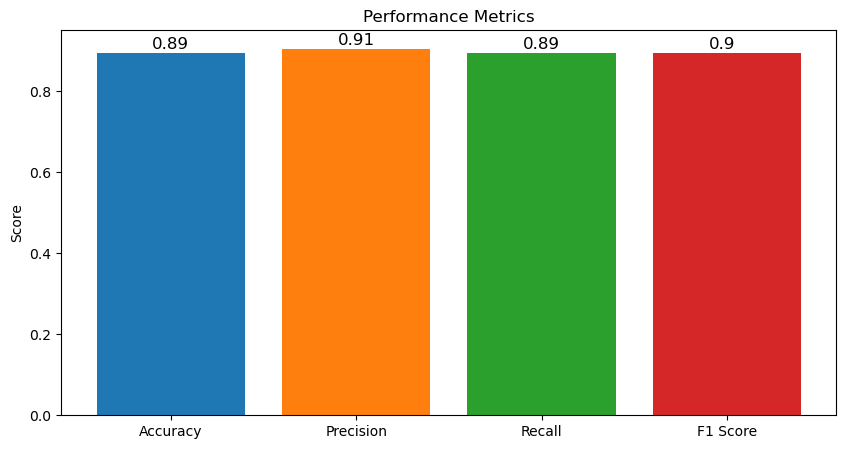

In [27]:
from keras.optimizers import RMSprop, SGD
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

# vysledny graf
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
fig = plt.figure(figsize=(10,5))
plt.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i-0.1, v+0.01, str(round(v, 2)), fontsize=12)
plt.show()

In [28]:
#AUTOMATIZACIA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.optimizers import RMSprop
import numpy as np

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability',
                'Emotion control importance', 'Game expectations', 'Emotion control during gaming',
                'Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness',
                'Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s',
                'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

# predpovedanie emocii
new_data = pd.read_csv('merged_data.csv')
new_data = new_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability','Emotion control importance', 'Game expectations', 'Emotion control during gaming','Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness','Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
new_data = scaler.transform(new_data)
new_predictions = model.predict(new_data)
new_emotions = le.inverse_transform(new_predictions.argmax(axis=-1))
print("Predicted emotions for new input:", new_emotions)

F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 61ms/step
Neural Network with oversampling and normalization Accuracy: 0.8421052631578947
Neural Network with oversampling and normalization Precision: 0.8614035087719298
Neural Network with oversampling and normalization Recall: 0.8421052631578947
Neural Network with oversampling and normalization F1 Score: 0.8368952684742158
2/2 [==============================] - 0s 2ms/step
Predicted emotions for new input: ['Calm' 'Calm' 'Frustrated' 'Calm' 'Calm' 'Calm' 'Excited' 'Calm'
 'Frustrated' 'Calm' 'Frustrated' 'Calm' 'Pleased' 'Calm' 'Calm' 'Pleased'
 'Excited' 'Pleased' 'Calm' 'Excited' 'Calm' 'Frustrated' 'Frustrated'
 'Calm' 'Frustrated' 'Pleased' 'Frustrated' 'Calm' 'Excited' 'Excited'
 'Calm' 'Calm' 'Pleased' 'Calm' 'Calm' 'Pleased' 'Calm' 'Pleased' 'Calm'
 'Calm']


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability',
                'Emotion control importance', 'Game expectations', 'Emotion control during gaming',
                'Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness',
                'Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s',
                'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=0)

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

new_data = pd.read_csv('merged_data.csv')
new_data = new_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability',                      'Emotion control importance', 'Game expectations', 'Emotion control during gaming',                      'Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness',                      'Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s',                      'average_speed']]
new_data = scaler.transform(new_data)
new_predictions = model.predict(new_data)
new_emotions = le.inverse_transform(new_predictions.argmax(axis=-1))
print("Predicted emotions for new input:", new_emotions)



F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 64ms/step
Neural Network with oversampling and normalization Accuracy: 0.8947368421052632
Neural Network with oversampling and normalization Precision: 0.9052631578947368
Neural Network with oversampling and normalization Recall: 0.8947368421052632
Neural Network with oversampling and normalization F1 Score: 0.8952684742158427
2/2 [==============================] - 0s 3ms/step
Predicted emotions for new input: ['Calm' 'Calm' 'Frustrated' 'Calm' 'Calm' 'Calm' 'Excited' 'Calm'
 'Frustrated' 'Calm' 'Frustrated' 'Calm' 'Pleased' 'Calm' 'Calm' 'Pleased'
 'Excited' 'Pleased' 'Calm' 'Excited' 'Calm' 'Frustrated' 'Calm' 'Calm'
 'Frustrated' 'Pleased' 'Frustrated' 'Calm' 'Excited' 'Excited' 'Calm'
 'Calm' 'Pleased' 'Calm' 'Calm' 'Pleased' 'Calm' 'Pleased' 'Calm' 'Calm']


In [7]:
# 5 k fold na rozdelenie dat a trening modelu
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import regularizers

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent', 'Platform', 'Genre', 'Game replayability',
                'Emotion control importance', 'Game expectations', 'Emotion control during gaming',
                'Game difficulty', 'Gaming frequency', 'Gaming hours per week', 'Age', 'Handedness',
                'Pohlavie', 'Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s',
                'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1s = []
f1_scores = []

for train_index, test_index in kf.split(X):
    # rozdelime data na trenovacie testovacie kvoli validacii
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # trening modelu
    model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# vysledne vypocty vratane chybovosti
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
print("Mean Precision:", mean_precision)
print("Standard Deviation of Precision:", std_precision)
print("Mean Recall:", mean_recall)
print("Standard Deviation of Recall:", std_recall)
print("Mean F1 Score:", mean_f1)
print("Standard Deviation of F1 Score:", std_f1)


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
Mean Accuracy: 0.968421052631579
Standard Deviation of Accuracy: 0.042105263157894736
Mean Precision: 0.9731578947368421
Standard Deviation of Precision: 0.037231029860689276
Mean Recall: 0.968421052631579
Standard Deviation of Recall: 0.042105263157894736
Mean F1 Score: 0.9688744004533477
Standard Deviation of F1 Score: 0.0417495595527683


In [10]:
from keras.optimizers import RMSprop, SGD
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

# ulozim model
model.save('my_model.h5')

Epoch 1/100


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 96ms/step - loss: 2.2687 - accuracy: 0.2603 - val_loss: 1.9762 - val_accuracy: 0.6316
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 1.9311 - accuracy: 0.5479 - val_loss: 1.8299 - val_accuracy: 0.7368
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 1.7901 - accuracy: 0.7123 - val_loss: 1.7122 - val_accuracy: 0.7368
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 1.6992 - accuracy: 0.7260 - val_loss: 1.6334 - val_accuracy: 0.8421
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 1.5981 - accuracy: 0.7671 - val_loss: 1.5493 - val_accuracy: 0.8421
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 1.5015 - accuracy: 0.8082 - val_loss: 1.4950 - val_accuracy: 0.8421
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 1.4378 - accuracy: 0.7945 - val_loss: 1.4397 - val_accuracy: 0.8947
Epoch 8/100
3/3 [===============

In [11]:
from tensorflow.keras.models import load_model

# nacitanie modelu
loaded_model = load_model('my_model.h5')


In [12]:
# automatizacia cista
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import load_model

model = load_model('my_model.h5')

new_data = pd.read_csv('merged_data.csv')

X_new = new_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y_new = new_data['Emotions while gaming']

le = LabelEncoder()
y_new = le.fit_transform(y_new)

scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

y_pred = model.predict(X_new)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred, average='weighted')
recall = recall_score(y_new, y_pred, average='weighted')
f1 = f1_score(y_new, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)


2/2 [==============================] - 0s 2ms/step
Neural Network with oversampling and normalization Accuracy: 0.9
Neural Network with oversampling and normalization Precision: 0.9175000000000001
Neural Network with oversampling and normalization Recall: 0.9
Neural Network with oversampling and normalization F1 Score: 0.90234403839055


In [2]:
from keras.optimizers import RMSprop
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

merged_data = pd.read_csv('merged_data.csv')

X = merged_data[['score', 'time_spent','Platform','Genre','Game replayability','Emotion control importance','Game expectations','Emotion control during gaming','Game difficulty','Gaming frequency','Gaming hours per week', 'Age','Handedness','Pohlavie','Expirience', 'clicks', 'just_clicks', 'avg_time_between_clicks_in_s', 'average_speed']]
y = merged_data['Emotions while gaming']

le = LabelEncoder()
y = le.fit_transform(y)

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Neural Network with oversampling and normalization Accuracy:", accuracy)
print("Neural Network with oversampling and normalization Precision:", precision)
print("Neural Network with oversampling and normalization Recall:", recall)
print("Neural Network with oversampling and normalization F1 Score:", f1)

y_test = le.inverse_transform(y_test)
y_pred = le.inverse_transform(y_pred)
table = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
print(table)

model.save('my_model.h5')


Epoch 1/100


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 107ms/step - loss: 2.0863 - accuracy: 0.4110 - val_loss: 1.8433 - val_accuracy: 0.6842
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.8354 - accuracy: 0.6027 - val_loss: 1.7089 - val_accuracy: 0.7368
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.6957 - accuracy: 0.6849 - val_loss: 1.6194 - val_accuracy: 0.7368
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.5786 - accuracy: 0.7945 - val_loss: 1.5543 - val_accuracy: 0.7368
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.4518 - accuracy: 0.8493 - val_loss: 1.5032 - val_accuracy: 0.7368
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.3872 - accuracy: 0.8767 - val_loss: 1.4373 - val_accuracy: 0.7368
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 1.3218 - accuracy: 0.8630 - val_loss: 1.3986 - val_accuracy: 0.7895
Epoch 8/100
3/3 [==============